# WORKFLOW 3

In [24]:
# IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [ ]:
# GLOBAL VARIABLES
theme_style = "darkgrid"
color_palette_style = "deep"
palette = sns.color_palette(color_palette_style)

# Set a warm-up phase (e.g., ignore the first 10 executions)
warmup_executions = 100  # Adjust as needed

days = [
    "2025-02-03", "2025-02-04", "2025-02-05", "2025-02-06", "2025-02-07", "2025-02-08", "2025-02-09"
]
day_labels = [
    "Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7"
]

window_size = 2

##### FUNCTIONS

In [47]:
# calculate break even
def calculate_break_even_day(baseline_df, optimized_df, warmup_executions=0):
    # Sort and prepare data
    baseline_df = baseline_df.sort_values(by="timestamp").reset_index(drop=True)
    optimized_df = optimized_df.sort_values(by="timestamp").reset_index(drop=True)

    # Convert timestamp to datetime
    baseline_df["timestamp"] = pd.to_datetime(baseline_df["timestamp"])
    optimized_df["timestamp"] = pd.to_datetime(optimized_df["timestamp"])

    # Compute cumulative execution time
    baseline_df["cumulative_time"] = baseline_df["execution_time"].cumsum()
    optimized_df["cumulative_time"] = optimized_df["execution_time"].cumsum()

    # Compute elapsed time in minutes
    baseline_df["duration_minutes"] = (baseline_df["timestamp"] - baseline_df["timestamp"].min()).dt.total_seconds() / 60
    optimized_df["duration_minutes"] = (optimized_df["timestamp"] - optimized_df["timestamp"].min()).dt.total_seconds() / 60

    # Trim the optimized function to match the length of the baseline function
    optimized_df_trimmed = optimized_df.iloc[:len(baseline_df)].reset_index(drop=True)

    # Find break-even point (ignore first N executions)
    break_even_index = (
        (optimized_df_trimmed["cumulative_time"] < baseline_df["cumulative_time"])
        & (optimized_df_trimmed.index >= warmup_executions)
    ).idxmax()

    return baseline_df, optimized_df, break_even_index

In [48]:
# calculate break even each day
def calculate_break_even_each_day():
    optimized_df_list = []
    baseline_df_list = []
    # List to hold break-even points for each day
    break_even_points = []
    break_even_indices = []

    # Loop through each day and calculate the break-even point
    for day in days:
        # Load the data for the current day
        baseline_df = pd.read_csv(f"./logs_analysis/{day}/execution_1/{day}-baselineFunction-logs.csv")
        optimized_df = pd.read_csv(f"./logs_analysis/{day}/execution_1/{day}-optimizedFunction-logs.csv")
        
        # Get the break-even point for this day
        baseline_df, optimized_df, break_even_index = calculate_break_even_day(baseline_df, optimized_df, warmup_executions)

        # Store the dataframes for later use
        baseline_df_list.append(baseline_df)
        optimized_df_list.append(optimized_df)

        # Calculate the break-even time and append it to the list
        break_even_time = baseline_df["duration_minutes"].iloc[break_even_index]
        break_even_points.append(break_even_time)
        break_even_indices.append(break_even_indices)

    return optimized_df_list, baseline_df_list, break_even_points, break_even_indices

In [49]:
# plot break even
def break_even_plot(baseline_df, optimized_df, break_even_index, day_label):
    # Create a Seaborn plot
    sns.set_style(theme_style)
    plt.figure(figsize=(5, 3))

    # Plot cumulative execution times with elapsed minutes
    sns.lineplot(x=optimized_df["duration_minutes"], y=optimized_df["cumulative_time"], label="Optimized Function", linestyle="--", color=palette[0])
    sns.lineplot(x=baseline_df["duration_minutes"], y=baseline_df["cumulative_time"], label="Baseline Function", linestyle="-", color=palette[1])

    # Mark the break-even point
    bep_time = baseline_df["duration_minutes"].iloc[break_even_index]
    plt.axvline(bep_time, color="red", linestyle="dotted", label=f"Break-even at {bep_time:.2f} min")
    
    # plt.yscale("log")
    
    # Labels and title
    plt.xlabel("Duration (min)")
    plt.ylabel("Cumulative Execution Time (ms)")
    plt.title(f"Break-Even Analysis: {day_label}")
    plt.legend()
    plt.show()

In [50]:
# plot break even grouped
def break_even_plot_grouped(df_all_days_optimized, df_all_days_baseline, optimized_df_list, baseline_df_list, break_even_points, avg_break_even, median_break_even, break_even_indices):
    # Create a Seaborn plot for all the days combined
    sns.set_style(theme_style)
    plt.figure(figsize=(8, 5))

    sns.lineplot(x=df_all_days_optimized["duration_minutes"], y=df_all_days_optimized["cumulative_time"], label=f"Optimized Function (median)", linestyle="-", color=palette[0])
    sns.lineplot(x=df_all_days_baseline["duration_minutes"], y=df_all_days_baseline["cumulative_time"], label=f"Baseline Function (median)", linestyle="-", color=palette[1])
    
    # Plot each day's cumulative execution times with elapsed minutes
    for idx, (baseline_df, optimized_df) in enumerate(zip(baseline_df_list, optimized_df_list)):    
        # Mark the break-even point for each day
        bep_time = baseline_df["duration_minutes"].iloc[baseline_df["duration_minutes"].searchsorted(break_even_points[idx])]
        plt.axvline(bep_time, color="gray", linestyle="dotted", alpha=0.5)

    # Add vertical lines for the average and median break-even times
    plt.axvline(avg_break_even, color=palette[3], linestyle="--", label=f"Average Break-even: {avg_break_even:.2f} min")
    plt.axvline(median_break_even, color=palette[4], linestyle="--", label=f"Median Break-even: {median_break_even:.2f} min")
    
    # Labels and title
    plt.xlabel("Duration (min)")
    plt.ylabel("Cumulative Execution Time (ms)")
    plt.title(f"Break-Even Analysis: All Days")
    plt.legend()
    plt.show()

In [51]:
# gather grouped data
def gather_optimized_all_days():
    # prepare optimized data
    df_list = []
    for date in days:
        file_path = f'./logs_analysis/{date}/execution_1/{date}-optimizedFunction-logs.csv'
        if os.path.exists(file_path):  # Check if file exists to avoid errors
            df = pd.read_csv(file_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
            df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
            df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

            df_list.append(df)
    
    # Concatenate all dataframes
    df_optimized_all_days = pd.concat(df_list, ignore_index=True)
    # Sort the dataframe by duration_minutes to ensure proper rolling calculations
    df_optimized_all_days = df_optimized_all_days.sort_values(by='duration_minutes')
    # Compute rolling median & std for optimized function
    df_optimized_all_days['smoothed_median'] = df_optimized_all_days['execution_time'].rolling(window=window_size, center=True).median()
    # Drop NaNs
    df_optimized_all_days = df_optimized_all_days.dropna(subset=['smoothed_median'])
    return df_optimized_all_days

def gather_baseline_all_days():
    # prepare optimized data
    df_list = []
    for date in days:
        file_path = f'./logs_analysis/{date}/execution_1/{date}-baselineFunction-logs.csv'
        if os.path.exists(file_path):  # Check if file exists to avoid errors
            df = pd.read_csv(file_path)
            df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
            df['duration_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60  # Normalize time
            df['smoothed_execution_time'] = df['execution_time'].rolling(window=window_size).mean()

            df_list.append(df)
    
    # Concatenate all dataframes
    df_baseline_all_days = pd.concat(df_list, ignore_index=True)
    # Sort the dataframe by duration_minutes to ensure proper rolling calculations
    df_baseline_all_days = df_baseline_all_days.sort_values(by='duration_minutes')
    # Compute rolling median & std for optimized function
    df_baseline_all_days['smoothed_median'] = df_baseline_all_days['execution_time'].rolling(window=window_size, center=True).median()
    # Drop NaNs
    df_baseline_all_days = df_baseline_all_days.dropna(subset=['smoothed_median'])
    return df_baseline_all_days

##### ALL DAYS INDIVIDUALLY

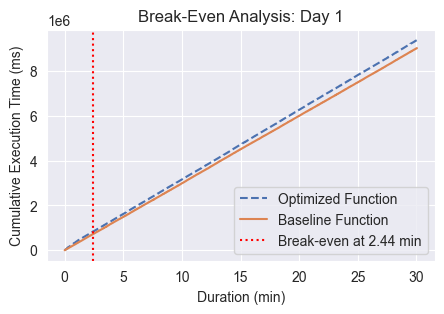

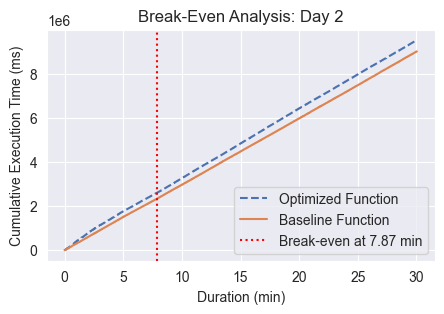

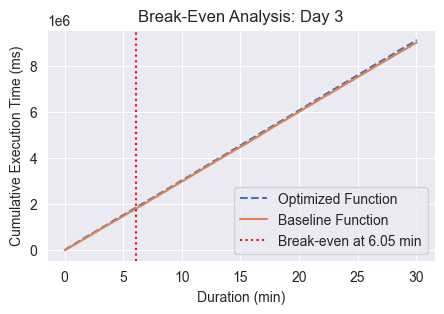

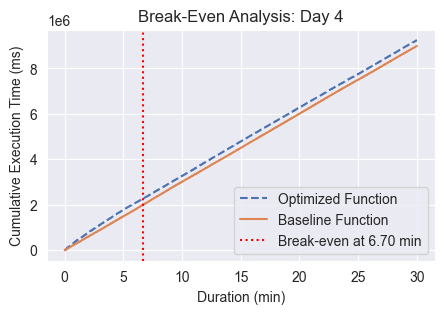

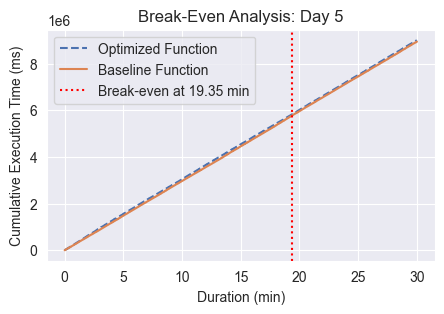

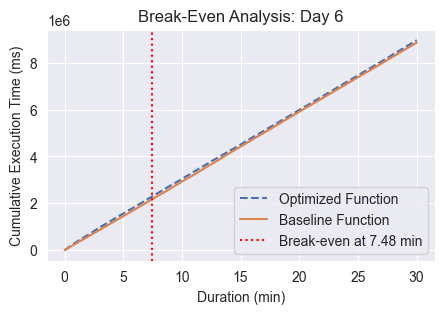

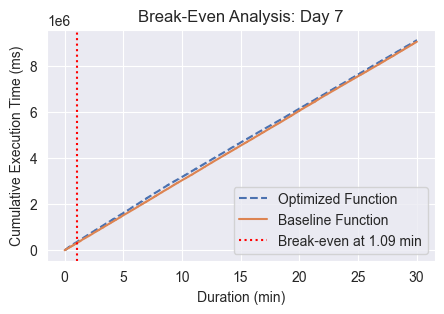

Average break-even time: 7.28 min
Median break-even time: 6.70 min


In [31]:
# execute break even for all 7 days
break_even_points = []

# Loop through each day and calculate the break-even point
for idx, day in enumerate(days):
    # Load the data for the current day
    baseline_df = pd.read_csv(f"./logs_analysis/{day}/execution_1/{day}-baselineFunction-logs.csv")
    optimized_df = pd.read_csv(f"./logs_analysis/{day}/execution_1/{day}-optimizedFunction-logs.csv")

    # Get the break-even point for this day
    baseline_df, optimized_df, break_even_index = calculate_break_even_day(baseline_df, optimized_df, warmup_executions)

    # Calculate the break-even time
    break_even_time = baseline_df["duration_minutes"].iloc[break_even_index]
    break_even_points.append(break_even_time)

    day_label = f"Day {idx + 1}"  # Day labels will start from "Day 1"
    break_even_plot(baseline_df, optimized_df, break_even_index, day_label)

    # Calculate the break-even time
    break_even_time = baseline_df["duration_minutes"].iloc[break_even_index]
    break_even_points.append(break_even_time)

# Calculate the average or median break-even point across all days
avg_break_even = sum(break_even_points) / len(break_even_points)
median_break_even = pd.Series(break_even_points).median()

print(f"Average break-even time: {avg_break_even:.2f} min")
print(f"Median break-even time: {median_break_even:.2f} min")

##### ALL DAYS GROUPED

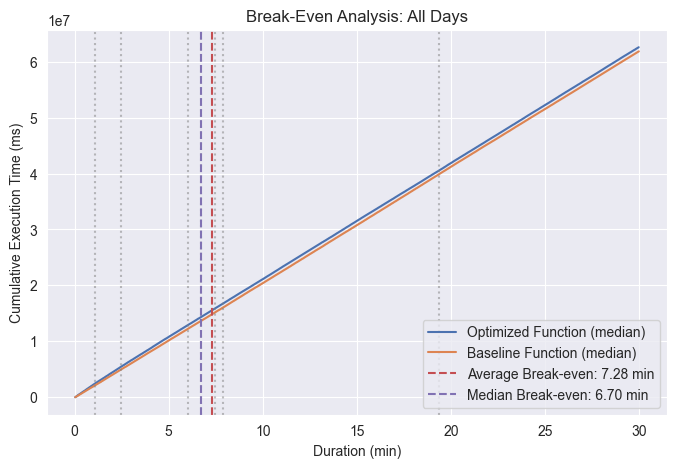

In [52]:
# GROUPED FIGURE
all_optimized_df = gather_optimized_all_days()
all_baseline_df = gather_baseline_all_days()

# Compute cumulative execution time
all_optimized_df["cumulative_time"] = all_optimized_df["smoothed_median"].cumsum()
all_baseline_df["cumulative_time"] = all_baseline_df["smoothed_median"].cumsum()

# Calculate break evens for each day
optimized_df_list, baseline_df_list, break_even_points, break_even_indices = calculate_break_even_each_day()
# Calculate the average and median break-even times
avg_break_even = sum(break_even_points) / len(break_even_points)
median_break_even = pd.Series(break_even_points).median()

# Plot the break-even analysis for all days combined
break_even_plot_grouped(all_optimized_df, all_baseline_df, optimized_df_list, baseline_df_list, break_even_points, avg_break_even, median_break_even, break_even_indices)

##### ARCHIVE